# Pet Insurance Customer Segmentation - EDA and Clustering

## 1 Introduction

### 1.1 Background
The Marketing department at a leading pet insurance provider is seeking to better understand its customer base to prevent customer loss and drive additional company revenue. Data suggests that customers are most likely to cancel their policies around the 2-year point following enrollment.   

### 1.2 Project Goal
The goal of this project is to identify 3-4 customer segments (with come justification for each) that will enable the Marketing team reduce customer shrinkage while improving outcomes related to targeted ads and/or direct-to-customer campaigns. 

Initial data suggests some key features that may be helpful for clustering include:
* Pet species (cat or dog)
* Amount of claims (in year 1, in year 2 and total)
* Number of claims (in year 1, in year 2 and total)
* Highest claim amount over the 2 year period
* Pet age

### 1.3 Data for EDA
During data wrangling, the PetData.csv and ClaimData.csv files were reviewed, cleaned and merged into a single dataset, merged_pets.csv.

### 1.4 Questions for EDA
The following is a list of some of the initial next steps identified for EDA based on the analysis completed during data wrangling.
* What relationships exist between some of the key features mentioned by the marketing team?
    * Pet species (cat or dog)
    * Amount of claims (in year 1, in year 2 and total)
    * Number of claims (in year 1, in year 2 and total)
    * Highest claim amount
    * Pet age
* Are there other features that look to be important in terms of clustering the customer base?

### 1.5 Questions for Clustering
1. How many customer segments naturally appear in the data?
2. Does this number of customer segments match up with the early guidance from Marketing that they expected to see 3-4?
3. For the observed segments, what are the primary differentiators?
4. What is our final recommendation for Marketing and what options do we see related to segmentation or mixing customer segments?

## 2 Setup

### 2.1 Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

### 2.2 Data Load & Preview

In [2]:
# Read in the data file generated during data wrangling
pets = pd.read_csv('../data/merged_pets.csv')

# Preview
pets.head(7).T

,0,1,2,3,4,5,6
PetId,0,1,2,3,4,5,6
Species,Dog,Dog,Dog,Dog,Dog,Dog,Cat
Breed,Schnauzer Standard,Yorkiepoo,Mixed Breed Medium,Labrador Retriever,French Bulldog,Shih Tzu,American Shorthair
Premium,84.54,50.33,74.0,57.54,60.69,43.53,47.4
Deductible,200,500,500,500,700,700,250
EnrollPath,Web,Phone,Phone,Phone,Web,Phone,Web
AgeYr1,3,0,0,0,0,2,0
MixedBreed,0,0,1,0,0,0,0
AmtClaimsYr1,0.0,0.0,640.63,0.0,7212.25,2665.67,0.0
AmtClaimsYr2,1242.0,0.0,1187.68,0.0,168.75,0.0,811.38


In [3]:
pets.shape

(50000, 18)

### 2.3 Data Wrangling Summary 
Before we get started on the analysis, let's take a moment to recap what we've learned so far and what the data looks like.

#### 2.3.1 What do we know? 
* **Shape** - Our clean dataframe is 50000 rows with each row corresponding to a single pet.
* **Basic Info** - For each pet, we have some basic info including species, breed, age at time of enrollment and enroll path.
* **Policy Info** - We also have policy-level info for each pet including the monthly premium and deductible amount for claims.
* **Claims Data** - We also have claims data for each pet covering the first two policy years including:
    * Number of claims per year and total (years 1 and 2 combined)
    * Average claim amount per year and total (years 1 and 2 combined) 
    * Amount of claims per year and total (years 1 and 2 combined)

#### 2.3.2 Initial Observations
* **Species** - We have two species of pets, Cats and Dogs
* **Breed** - We have 373 unique breeds in total (55 cat and 318 dog)
* **Age** - The age range is between 0 (i.e., < 1 year) and 13
* **Premium** - Premiums fall into a wide range with a few outlier values close to \\$1000
* **Deductible** - Deductibles are fairly well distributed and appear to be stratified across a range of common values.
* **Claims** 
    * For cats and dogs, the median value for total number and total amount of claims is 0.
    * On the flip side, both species have some significant outliers in both categories (number and amount of claims)
    
Now that we have a bit more context, let's jump in to the analysis.

## 3 Data Analysis

### 3.1 What is the count of pets per species?

In [4]:
pets.Species.value_counts()

Dog    41976
Cat     8024
Name: Species, dtype: int64

As observed in data wrangling, we have approximately 50,000 pets in our data, roughly 85% of which are dogs. The remaining 15% are cats, so that keeps things fairly simple as we only have two breeds to consider. 

### 3.2 How do species compare in terms of total claims amounts?

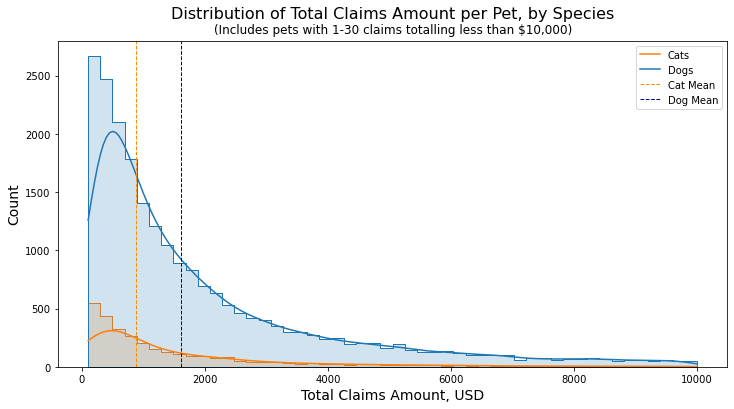

In [5]:
# Filter out outliers for number of claims and claim amounts
claim_filter = pets[(pets.AmtClaimsTotal < 10000) & (pets.AmtClaimsTotal > 100) &
                 (pets.NumClaimsTotal < 30) & (pets.NumClaimsTotal > 0)]

# Calculate mean values
dog_mean = pets[pets.Species == 'Dog']['AmtClaimsTotal'].mean()
cat_mean = pets[pets.Species == 'Cat']['AmtClaimsTotal'].mean()

# Create a histogram showing premium amounts by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(x="AmtClaimsTotal", data=claim_filter, hue="Species", alpha=0.2,
             element='step', bins=50, kde=True)

# Plot mean premium amount for dogs and cats
plt.axvline(cat_mean, color='darkorange', linestyle='dashed', linewidth=1)
plt.axvline(dog_mean, color='darkblue', linestyle='dashed', linewidth=1)

# Add title and display plot
plt.title("Distribution of Total Claims Amount per Pet, by Species", y=1.05, fontsize=16)
plt.suptitle("(Includes pets with 1-30 claims totalling less than $10,000)", y=0.92, x=0.513, fontsize=12)
plt.xlabel("Total Claims Amount, USD", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(labels=(['Cats', 'Dogs', 'Cat Mean', 'Dog Mean']), loc='upper right')
plt.savefig('../figures/Total-Claims-by-Species.png')
plt.show()

We see in the distribution above that dogs tend to have higher total claims over the first 2 policy years compared to cats. Next, let's take a look at the raw averages with outliers included to see if it shows a similar difference.

In [6]:
print("Dogs - Avg Total Claims: $" + str(int(round(pets[pets.Species == 'Dog']['AmtClaimsTotal'].mean(),0))))
print("Cats - Avg Total Claims: $" + str(int(round(pets[pets.Species == 'Cat']['AmtClaimsTotal'].mean(),0))))

Dogs - Avg Total Claims: $1606
Cats - Avg Total Claims: $877


Looking at the average total claims amounts for cats and dogs with outliers included, we see that **the average total claims for dogs is nearly 2x greater than the average total claims for cats.**

This seems to be somewhat significant and likely to be a factor when segmenting our customer base later on. Next, let's see if the same holds true for the total number of claims per pet.

### 3.3 Do dog owners submit more claims than cat owners?

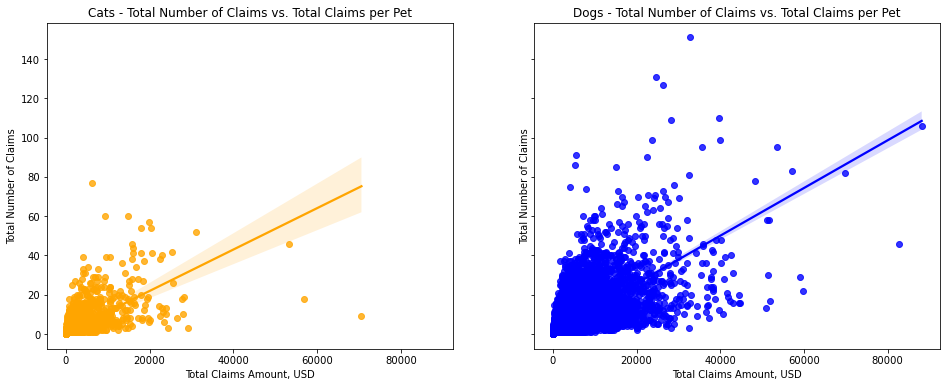

In [7]:
# Create regplots showing number of claims vs total claims amount by species
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
sns.regplot(x="AmtClaimsTotal", y="NumClaimsTotal", data=pets[pets.Species == 'Cat'], ax=ax1,
            color="Orange").set(title="Cats - Total Number of Claims vs. Total Claims per Pet",
                                xlabel="Total Claims Amount, USD", ylabel="Total Number of Claims")
sns.regplot(x="AmtClaimsTotal", y="NumClaimsTotal", data=pets[pets.Species == 'Dog'], ax=ax2,
            color="Blue").set(title="Dogs - Total Number of Claims vs. Total Claims per Pet", 
                              xlabel="Total Claims Amount, USD", ylabel="Total Number of Claims")

plt.show()

In the plot above, we see very similar patterns in terms of the number and amount of claims between species. Generally though, it does appear cat owners tend to submit fewer claims than dog owners. Let's take a look at a countplot for a closer look. Again, we'll apply the claim filter to make the result more interpretable.

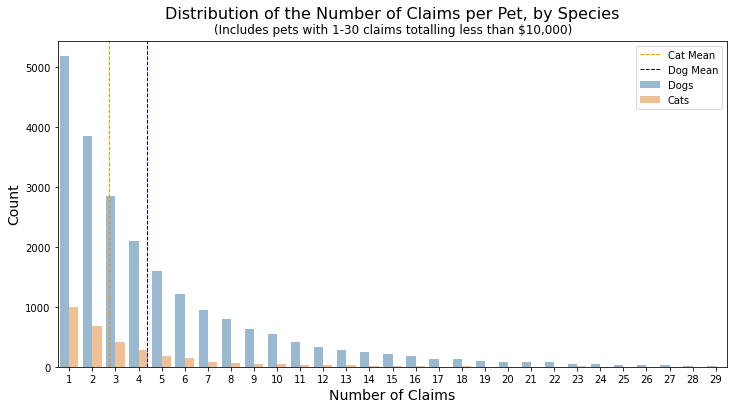

In [8]:
# Calculate mean values
dog_mean = pets[pets.Species == 'Dog']['NumClaimsTotal'].mean()
cat_mean = pets[pets.Species == 'Cat']['NumClaimsTotal'].mean()

# Create a countplot 
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.countplot(x="NumClaimsTotal", data=claim_filter, hue="Species", alpha=0.5)

# Plot mean premium amount for dogs and cats
plt.axvline(cat_mean, color='darkorange', linestyle='dashed', linewidth=1, label="Cat Mean")
plt.axvline(dog_mean, color='darkblue', linestyle='dashed', linewidth=1, label="Dog Mean")

# Add title and display plot
plt.title("Distribution of the Number of Claims per Pet, by Species", y=1.05, fontsize=16)
plt.suptitle("(Includes pets with 1-30 claims totalling less than $10,000)", y=0.92, x=0.513, fontsize=12)
plt.xlabel("Number of Claims", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(labels=(['Cat Mean', 'Dog Mean', 'Dogs', 'Cats']), loc='upper right')
plt.savefig('../figures/Number-Claims-by-Species.png')
plt.show()

Looking at the distributions of number of claims for each species, we see that both are heavily right skewed. This plot also makes it easier to see the difference in terms of the average number of claims by species. Unsurprisingly, dog owners do tend to submit a greater number of claims on average when compared with cat owners over the 2 year span. 

### 3.4 How many pets have claims in one or both years?
We've seen that generally speaking, dogs tend to have more claims than cats. And during data wrangling, we observed that a significant number of pets have no claims at all within the first two years. 

**But what trends do we see for pets with claims in one or both years?** 
* Do the majority have claims in both years or only one year? 
* Additionally, are there any patterns that jump out when we look at pets with claims in both years in terms of species or age?

First, let's create a basic function to determine for each pet, if they have no claims, claims in one year (either year 1 or year 2), or claims in both years. Then we can plot our results to see if anything interesting jumps out.

In [9]:
# Create function to populate new column as count of number of years with claims (0, 1, 2)
def claim_yrs(row):
    if (row["NumClaimsTotal"] == 0):
        return 0
    elif ((row["NumClaimsYr1"] > 0) & (row["NumClaimsYr2"] > 0)):
        return 2
    else:
        return 1

# Apply function to df to create new column
pets["YrsWithClaims"] = pets.apply(claim_yrs, axis=1)

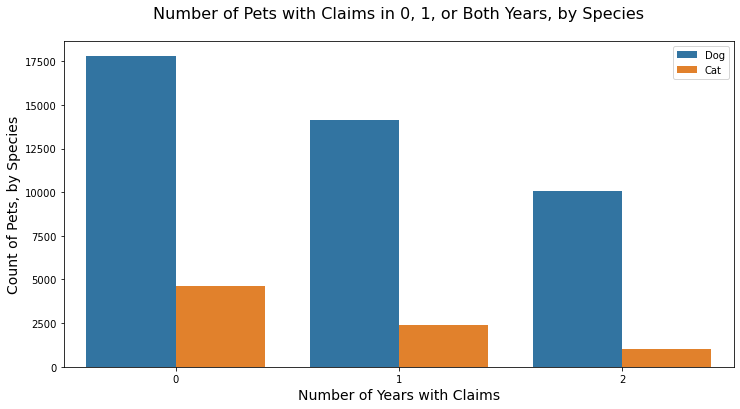

In [10]:
# Plot the count of pets with claims in 0, 1 or both years
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
palette ={"Dog": "#1f77b4", "Cat": "#ff7f0e"}
sns.countplot(x='YrsWithClaims', data=pets, hue="Species", palette=palette)

# Plot the legend and display
plt.title("Number of Pets with Claims in 0, 1, or Both Years, by Species", y=1.05, fontsize=16)
plt.xlabel("Number of Years with Claims", fontsize=14)
plt.ylabel("Count of Pets, by Species", fontsize=14)
plt.legend(loc='upper right')
plt.savefig('../figures/Claims-by-PolicyYear.png')
plt.show()

As noted earlier, the majority of pets in our data (and for each species) have no claims at all in the two years included in the dataset. And again, we see similar looking trends between species in terms of the counts at 0, 1 and 2 years, but it's hard to make out any differences since the dataset is unbalanced toward dogs by nearly 6 to 1. 

Let's see if plotting this based on the percentage of each species with claims in 0, 1 or 2 years highlights any differences. 

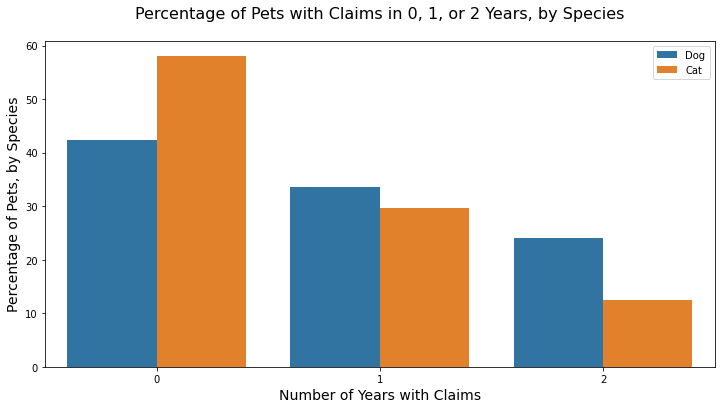

In [11]:
# Calculate the percentage of each species with claims in 0,1, or 2 years
claim_yr_counts = (pets.groupby(['Species'])['YrsWithClaims']
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('YrsWithClaims'))

# Plot the data 
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
palette ={"Dog": "#1f77b4", "Cat": "#ff7f0e"}
hue_order = ['Dog', 'Cat']
sns.barplot(x="YrsWithClaims", y="Percentage", hue="Species", palette=palette, hue_order=hue_order, 
            data=claim_yr_counts)

# Plot the legend and display
plt.title("Percentage of Pets with Claims in 0, 1, or 2 Years, by Species", y=1.05, fontsize=16)
plt.xlabel("Number of Years with Claims", fontsize=14)
plt.ylabel("Percentage of Pets, by Species", fontsize=14)
plt.legend(loc='upper right')
plt.savefig('../figures/Claims-by-PolicyYear.png')
plt.show()

By plotting the percentages of each species with claims in zero, one, or both years, the results are easier to interpret. We see that cats are less likely to have claims overall and dogs are more likely to have claims in one or both policy years. In fact, dogs are almost twice as likely to have claims in both policy years than cats. 

### 3.5 How much does pet age matter when it comes to claims?

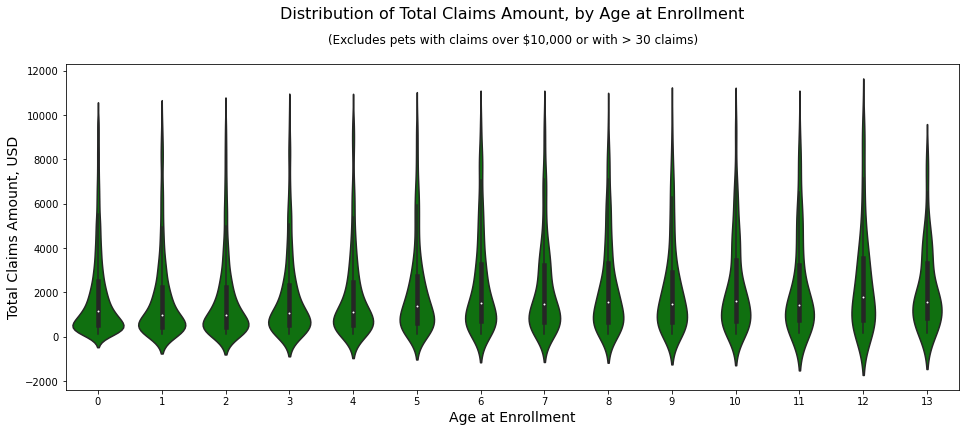

In [12]:
# Create a violin plot showing distribution of total claims based on year of enrollment
f, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.violinplot(x="AgeYr1", y="AmtClaimsTotal", data=claim_filter, color="Green")

# Add titles and display
plt.xlabel("Age at Enrollment", fontsize=14)
plt.ylabel("Total Claims Amount, USD", fontsize=14)
plt.title("Distribution of Total Claims Amount, by Age at Enrollment", y=1.12, fontsize=16)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.95, x=0.513, fontsize=12)
plt.show()

At a high level, the violin plot shows the distribution of total claims amounts changing with age. As age increases, we see the spread of total claims amounts increasing as well. That said, the details of the distribution are difficult to make out in this view and it's tough to know if there is anything significant going on or not.

Let's try grouping pets by age-range to see if any interesting trends stand out.

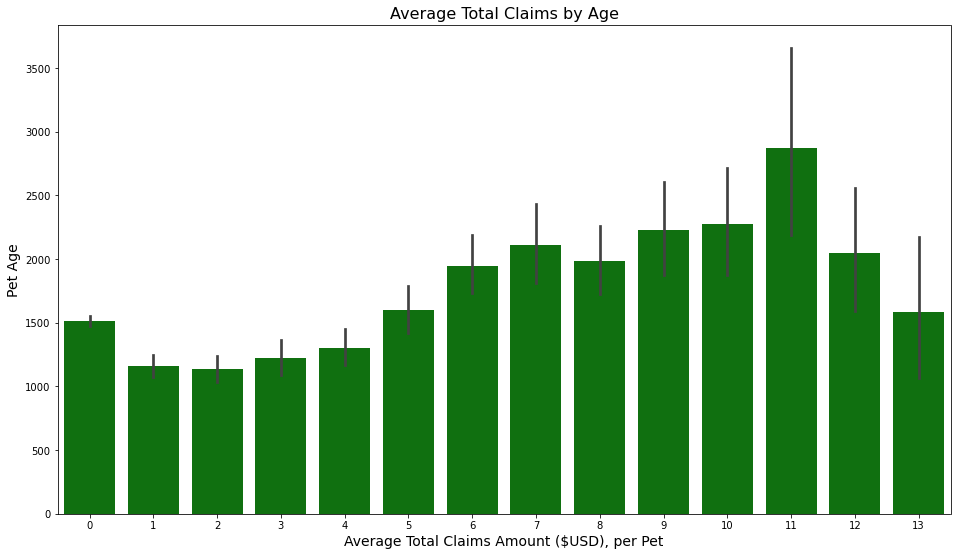

In [13]:
# Create horizontal barplot
plt.figure(figsize=(16,9))
sns.barplot(x="AgeYr1", y="AmtClaimsTotal", data=pets, color="green")
plt.xlabel("Average Total Claims Amount ($USD), per Pet", fontsize=14)
plt.ylabel("Pet Age", fontsize=14)
plt.title("Average Total Claims by Age", fontsize=16)
plt.show()

The bar plot provides a better perspective on the relationship between age and total claims amount. We can see that the average total claims amount tends to rise with age until approximately age 11. In addition, the error bars indicate the same increase in variability in the total claims amounts as pets age that we observed in the violin plot. Based on this result, it will be interesting to see how age factors in to our final customer segments.

### 3.6 Feature correlation
So far we've observed a few trends in the data related to species, claims and pet ages. Next, let's create a correlation matrix to see if any other strong relationships are visible in our data set.

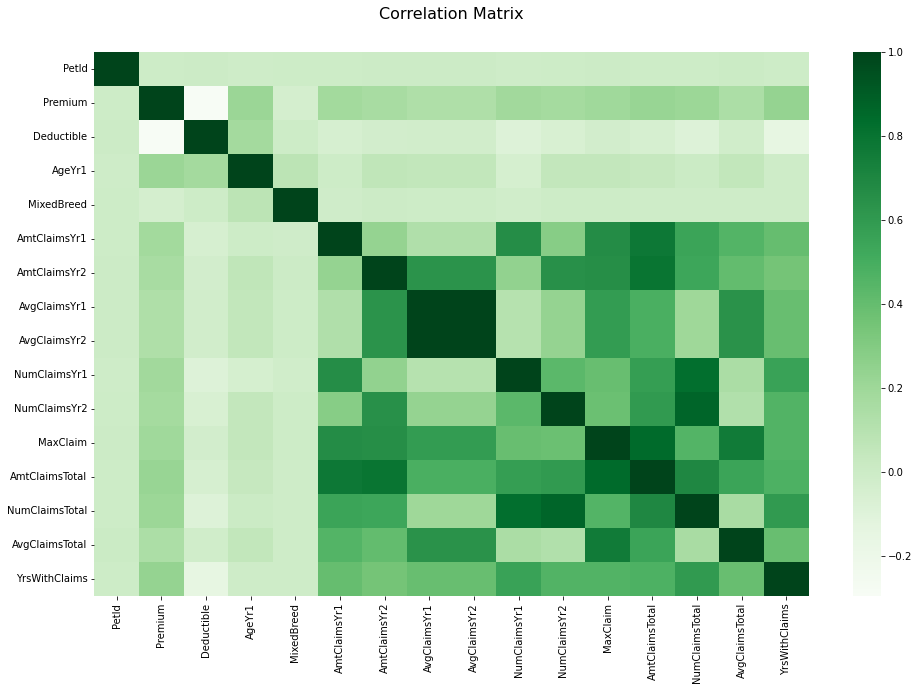

In [14]:
# Create correlation matrix
pets_corr = pets.corr()

# Plot the corresponding heatmaps
plt.figure(figsize=(16,10))
_ = sns.heatmap(pets_corr, cmap="Greens")
plt.title("Correlation Matrix", y=1.05, fontsize=16)
plt.savefig('../figures/Feature-Correlation.png')
plt.show()

We do see some positive correlations in the 0.6 and higher range, but these stronger correlations are mostly between our claims-related features (e.g. MaxClaim and AmtClaimsTotal) which seem very logical.

Given that we aren't seeing anything particularly interesting in the correlation matrix, let's take a different approach and try using PCA to better understand which features are contributing the most to the variance in our data. 

## 4 Principle Components Analysis
The steps we'll follow for PCA include:

1. Prep of the data to remove non-numeric features
2. Scale our features to normalize the data
3. Fit the PCA transformation 
4. Apply the transformation to the data to create derived features
5. Determine feature importance for our derived features

### 4.1 Data prep
Before we can start PCA, we need to do a bit of prep work on our data to remove categorical features (Species, Breed and EnrollPath). For now, we'll save the categorical features as a new dataframe so we can refer back to it later for interpretation of the results.

In [15]:
# Create a new dataframe with the categorical features
pets_categorical = pets[['PetId', 'Species', 'Breed', 'EnrollPath']]

# Save the new df to a file
pets_categorical.to_csv('../data/pets_categorical.csv')

In [16]:
# Drop unnecessary columns
pets.drop(columns=["PetId", "Species", "Breed", "EnrollPath", "MixedBreed"], axis=1, inplace=True)
pets.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Premium,84.54,50.33,74.00,57.54,60.69,43.53,47.40,75.14,24.52,41.07,80.83,45.65,47.42,115.33,28.35
Deductible,200.00,500.00,500.00,500.00,700.00,700.00,250.00,700.00,250.00,500.00,200.00,500.00,200.00,200.00,1000.00
AgeYr1,3.00,0.00,0.00,0.00,0.00,2.00,0.00,5.00,2.00,1.00,0.00,0.00,6.00,0.00,0.00
AmtClaimsYr1,0.00,0.00,640.63,0.00,7212.25,2665.67,0.00,2873.47,0.00,0.00,13983.42,914.05,0.00,0.00,0.00
AmtClaimsYr2,1242.00,0.00,1187.68,0.00,168.75,0.00,811.38,2497.03,0.00,0.00,4913.93,903.06,2408.68,903.26,0.00
AvgClaimsYr1,621.00,0.00,237.54,0.00,168.75,0.00,811.38,356.72,0.00,0.00,818.99,225.76,401.45,451.63,0.00
AvgClaimsYr2,621.00,0.00,237.54,0.00,168.75,0.00,811.38,356.72,0.00,0.00,818.99,225.76,401.45,451.63,0.00
NumClaimsYr1,0.00,0.00,3.00,0.00,9.00,9.00,0.00,7.00,0.00,0.00,21.00,9.00,0.00,0.00,0.00
NumClaimsYr2,2.00,0.00,5.00,0.00,1.00,0.00,1.00,7.00,0.00,0.00,6.00,4.00,6.00,2.00,0.00
MaxClaim,624.00,0.00,336.56,0.00,3103.40,960.18,811.38,1110.88,0.00,0.00,2558.62,469.91,1192.23,648.42,0.00


### 4.2 Feature Scaling
Next, we need to scale our features to account for the fact that our data includes features on vastly different scales. For example, 'YrsWithClaims' is an integer value of 0, 1, or 2 and by contrast, 'AmtClaimsTotal' consists of continuous values ranging from 0 to 60,000+.

As we've seen so far, most of our data distributions are heavily right skewed. This can sometimes lead to issues when using a standard scaler. So in this case, we'll utilize the PowerTransformer() method which should help to give the scaled features a more normal, Gaussian distribution. 

In [17]:
# Create a copy of the pets df for scaling
pets_scale = pets.copy()

# Save column names for later
pets_scale_columns = pets_scale.columns

# Scale the data
pt = PowerTransformer()
pets_scaled_df = pd.DataFrame(pt.fit_transform(pets_scale), columns=pets_scale_columns)

# Preview the result
pets_scaled_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
Premium,0.848244,-0.226413,0.580831,0.059580,0.171767,-0.543277,-0.356490,0.611829,-1.864856,-0.672250
Deductible,-0.972698,0.169764,0.169764,0.169764,0.751004,0.751004,-0.743701,0.751004,-0.743701,0.169764
AgeYr1,1.395157,-0.743415,-0.743415,-0.743415,-0.743415,1.211278,-0.743415,1.558197,1.211278,0.794161
AmtClaimsYr1,-0.855920,-0.855920,1.112672,-0.855920,1.468109,1.337952,-0.855920,1.348487,-0.855920,-0.855920
AmtClaimsYr2,1.426986,-0.723202,1.423018,-0.723202,1.187936,-0.723202,1.387009,1.482629,-0.723202,-0.723202
AvgClaimsYr1,1.452415,-0.723953,1.347311,-0.723953,1.300900,-0.723953,1.476063,1.395981,-0.723953,-0.723953
AvgClaimsYr2,1.452415,-0.723953,1.347311,-0.723953,1.300900,-0.723953,1.476063,1.395981,-0.723953,-0.723953
NumClaimsYr1,-0.832376,-0.832376,1.267941,-0.832376,1.659418,1.659418,-0.832376,1.595687,-0.832376,-0.832376
NumClaimsYr2,1.346111,-0.712337,1.654532,-0.712337,0.940906,-0.712337,0.940906,1.712755,-0.712337,-0.712337
MaxClaim,0.853834,-1.073549,0.663518,-1.073549,1.355040,0.987568,0.935233,1.032963,-1.073549,-1.073549


### 4.3 Calculate the PCA Transformation
Now that the data is scaled, we are ready for PCA. To start, we'll fit the PCA transformation using our scaled dataframe. Then we'll plot the cumulative explained variance for the resulting components.

In [18]:
# Fit the PCA transformation using the scaled data
pets_pca = PCA().fit(pets_scaled_df)

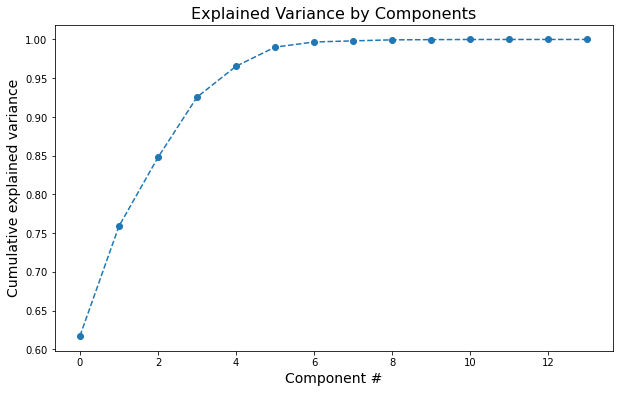

In [19]:
# Plot the cumulative variance ratio with number of components
plt.subplots(figsize=(10, 6))
plt.plot(pets_pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Component #', fontsize=14)
plt.ylabel('Cumulative explained variance', fontsize=14)
plt.title('Explained Variance by Components', fontsize=16)
plt.savefig('../figures/Explained-Variance-by-Component.png')
plt.show()

Based on the plot above, we see that the first 3 components explain over 85% of the variance and the first 5 components explain over 95% of the variance in the data. As a rule of thumb, it's generally good to maintain around 80% of the variance in the data. So in our case, we'll go with 3 components.

### 4.4 Apply the transformation to the data 
Next, we'll apply the transformation to our scaled data, but first, we'll perform PCA with our desired number of components (i.e., 3). After applying the transoformation, we can generate a scatterplot of the first two components to see if any patterns or clusters jump out.

In [20]:
# Fit the PCA transformation using the scaled data with the desired number of components
pets_pca = PCA(n_components=3).fit(pets_scaled_df)

In [21]:
# Apply the transformation to the data
pets_pca_x = pets_pca.transform(pets_scaled_df)

# View the shape
pets_pca_x.shape

(50000, 3)

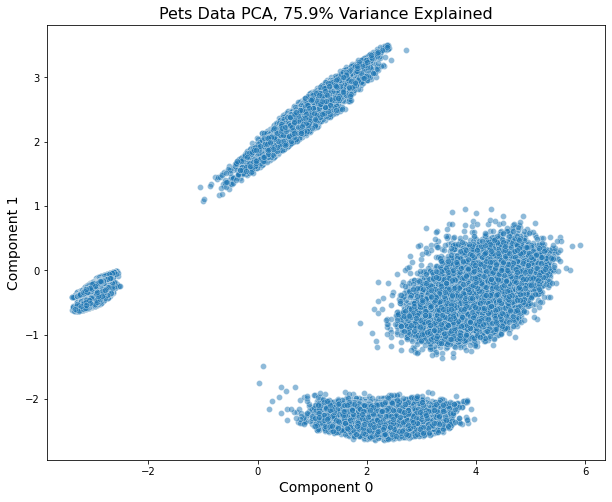

In [22]:
# Isolate the top two components from PCA
x = pets_pca_x[:, 0]
y = pets_pca_x[:, 1]

# Plot a scatterplot of the top two components
pc_var = 100 * pets_pca.explained_variance_ratio_.cumsum()[1]
plt.figure(figsize=(10,8))
sns.scatterplot(x=x, y=y, data=pets_pca_x, alpha=0.5)
plt.xlabel('Component 0', fontsize=14)
plt.ylabel('Component 1', fontsize=14)
plt.title(f'Pets Data PCA, {pc_var:.1f}% Variance Explained', fontsize=16)
plt.savefig('../figures/PCA-Scatterplot.png')
plt.show()

In the plot above, we can see 4 distinct grouping are visible. This could be an indication that we have 4 well-defined customer segments in the data. As a next step, let's take a look at our 3 components to understand which of our original features contributed most to each component.

### 4.5 Determining feature importance

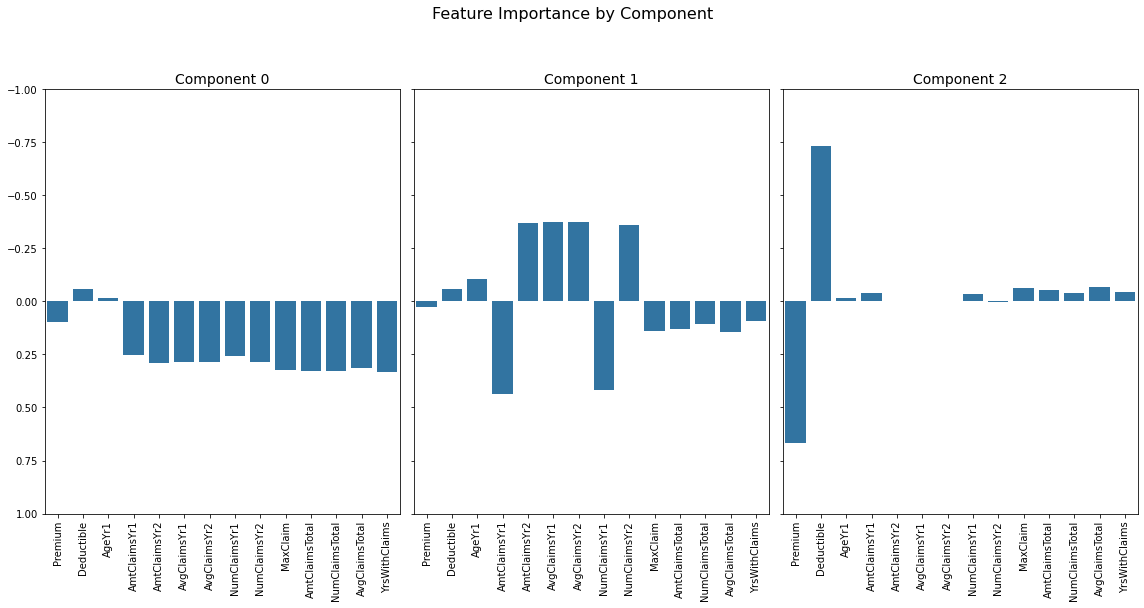

In [26]:
# Create a barplot of feature importances by component
# Set x values and labels to feature names
x = pets_scale_columns

# Create plot
f, axs = plt.subplots(1, 3, figsize=(16,8), sharey=True)
plt.ylim(1, -1)
sns.barplot(x=x, y=pets_pca.components_[0], ax=axs[0], color="#1f77b4").set_xticklabels(x, rotation = 90)
sns.barplot(x=x, y=pets_pca.components_[1], ax=axs[1], color="#1f77b4").set_xticklabels(x, rotation = 90)
sns.barplot(x=x, y=pets_pca.components_[2], ax=axs[2], color="#1f77b4").set_xticklabels(x, rotation = 90)

axs[0].set_title("Component 0", fontsize=14)
axs[1].set_title("Component 1", fontsize=14)
axs[2].set_title("Component 2", fontsize=14)
plt.suptitle("Feature Importance by Component", y=1.05, fontsize=16)
plt.tight_layout()
plt.savefig('../figures/Feature-Importance-by-Component.png')
plt.show()

In [27]:
# Create a df of feature name and importance for each PCA component
n_pcs = pets_pca.components_.shape[0] 
feature_importance = [] 

# Loop through the results for each component and capture the ranked feature names and relative importance
for i in range(n_pcs):
    l = pets_pca.components_[i]
    abs_l = [abs(x) for x in l] 
    sorted_index = np.flip(np.argsort(abs_l))
    sorted_features = [(pets_scale_columns[item], l[item]) for item in sorted_index] 
    feature_importance.append(sorted_features)

# Create a dataframe of the results
feature_importance = pd.DataFrame(feature_importance)
feature_importance = feature_importance.transpose()
feature_importance.columns = ["Component_" + str(i) for i in range(n_pcs)]

# Preview
feature_importance.head(14)

,Component_0,Component_1,Component_2
0,"(YrsWithClaims, 0.332977317682439)","(AmtClaimsYr1, 0.4384632511209357)","(Deductible, -0.7344106904949124)"
1,"(AmtClaimsTotal, 0.32753790922542086)","(NumClaimsYr1, 0.4156919561233554)","(Premium, 0.6652233710886717)"
2,"(NumClaimsTotal, 0.32603579073795036)","(AvgClaimsYr2, -0.37219922823356566)","(AvgClaimsTotal, -0.06612033989702334)"
3,"(MaxClaim, 0.32141403315114514)","(AvgClaimsYr1, -0.37219922823356555)","(MaxClaim, -0.061584614892716)"
4,"(AvgClaimsTotal, 0.3124390071549774)","(AmtClaimsYr2, -0.3699190096697315)","(AmtClaimsTotal, -0.05530303809974128)"
5,"(AmtClaimsYr2, 0.2887128086361765)","(NumClaimsYr2, -0.3577464427388598)","(YrsWithClaims, -0.04523348506084711)"
6,"(NumClaimsYr2, 0.28805921359396836)","(AvgClaimsTotal, 0.14615691530960875)","(AmtClaimsYr1, -0.04124678049846798)"
7,"(AvgClaimsYr2, 0.2874460718630027)","(MaxClaim, 0.1383941534316809)","(NumClaimsTotal, -0.04044054218022048)"
8,"(AvgClaimsYr1, 0.28744607186300264)","(AmtClaimsTotal, 0.13024002554247235)","(NumClaimsYr1, -0.03487846693230905)"
9,"(NumClaimsYr1, 0.2554876131251752)","(AgeYr1, -0.10723028135871862)","(AgeYr1, -0.016158392023097004)"


Looking at Component 0, we see that several features seem to contribute almost equally in terms of importance with 'YrsWithClaims' leading the way. Close behind 'YrsWithClaims' we see all of our 'Totals' features (Amount, Number and Average) along with 'MaxClaim'. 

For Component 1, we see a larger spread between the first 6 most important features and the last 8. In this case, the important features are related to aggregates by year (e.g., AmtClaimsYr1, NumClaimsYr1, etc.). 

And finally, component 3 looks to be driven primarily by 2 of our original features, premium and deductible.

All of this likely points to a conclusion that the claims data will play a significant factor in our different customer segments. Next, let's apply a couple of different clustering methods to our data to see if the clusters match up with what we observed in PCA.

## 5 Determine Number of Clusters using K-Means

As a next step, we'll use K-Means to try and identify clusters in our data. To start, we'll fit a K-Means model using the transformed data from PCA and then we'll plot the result to see if we can identify the ideal number of clusters in our data.

### 5.1 Fit K-means using the transformed data from PCA

In [28]:
# Generate list for 'Within Cluster Sum of Squares' for each cluster value
wcss = []

for i in range(1,11):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(pets_pca_x)
    wcss.append(kmeans_pca.inertia_)

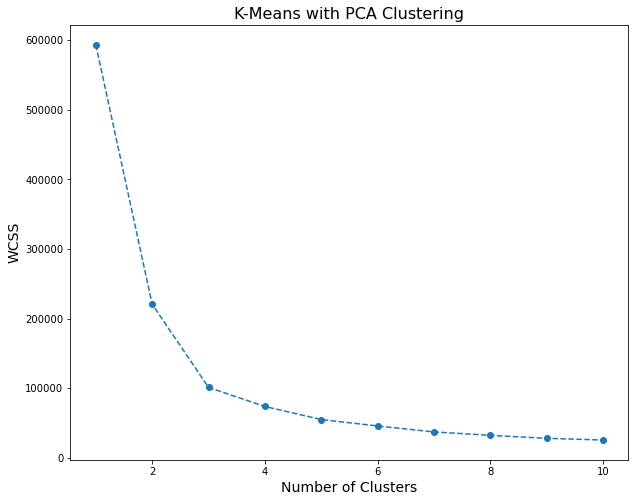

In [29]:
# Plot the result
plt.figure(figsize=(10,8))
plt.plot(range(1,11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("WCSS", fontsize=14)
plt.title("K-Means with PCA Clustering", fontsize=16)
plt.savefig('../figures/K-Means-Elbow-Plot.png')
plt.show()

From the graph above, we can use the line to determine the number of clusters we’d like to keep by using the  Elbow-method. We can see that there is an 'elbow' in the graph at the point where the steep decline starts to flatten out. In our case, this looks to be at the 3 cluster mark. 

This observation matches up well with the initial instructions from Marketing that they expected to see 3-4 clusters in the data. Based on the fact that we observed 4 very distinct clusters earlier while performing PCA, let's start with 4. We can adjust later back to 3 if needed depending on the results of our analysis.

### 5.2 Implement K-Means with our chosen number of clusters

In [30]:
# Implement k-means with our chosen number of clusters and the same parameters as earlier
kmeans_pca = KMeans(n_clusters=4, random_state=42)

# Fit our data with the kmeans pca model
kmeans_pca.fit(pets_pca_x)

KMeans(n_clusters=4, random_state=42)

### 5.3 Add PCA components and K-Means clusters as new features

In [31]:
# Create new df with original features + PCA results
pets_pca_kmeans = pd.concat([pets.reset_index(drop=True), pd.DataFrame(pets_pca_x)], axis=1)
pets_pca_kmeans.columns.values[-3: ] = ["Component_0", "Component_1", "Component_2"]

# Add results of K-Means clustering as a new feature
pets_pca_kmeans["Segment"] = kmeans_pca.labels_

# Preview the result
pets_pca_kmeans.head(10).T

,0,1,2,3,4,5,6,7,8,9
Premium,84.540000,50.330000,74.000000,57.540000,60.690000,43.530000,47.400000,75.140000,24.520000,41.070000
Deductible,200.000000,500.000000,500.000000,500.000000,700.000000,700.000000,250.000000,700.000000,250.000000,500.000000
AgeYr1,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,5.000000,2.000000,1.000000
AmtClaimsYr1,0.000000,0.000000,640.630000,0.000000,7212.250000,2665.670000,0.000000,2873.470000,0.000000,0.000000
AmtClaimsYr2,1242.000000,0.000000,1187.680000,0.000000,168.750000,0.000000,811.380000,2497.030000,0.000000,0.000000
AvgClaimsYr1,621.000000,0.000000,237.540000,0.000000,168.750000,0.000000,811.380000,356.720000,0.000000,0.000000
AvgClaimsYr2,621.000000,0.000000,237.540000,0.000000,168.750000,0.000000,811.380000,356.720000,0.000000,0.000000
NumClaimsYr1,0.000000,0.000000,3.000000,0.000000,9.000000,9.000000,0.000000,7.000000,0.000000,0.000000
NumClaimsYr2,2.000000,0.000000,5.000000,0.000000,1.000000,0.000000,1.000000,7.000000,0.000000,0.000000
MaxClaim,624.000000,0.000000,336.560000,0.000000,3103.400000,960.180000,811.380000,1110.880000,0.000000,0.000000


In [32]:
# Add names for each of our segments
pets_pca_kmeans["Segment"] = pets_pca_kmeans["Segment"].map({0: 'segment_1', 1: 'segment_2',
                                                             2: 'segment_3', 3: 'segment_4'})
# Set categorical order of segments for plotting
pets_pca_kmeans["Segment"] = pd.Categorical(pets_pca_kmeans["Segment"] ,
                                   categories=['segment_1', 'segment_2', 'segment_3', 'segment_4'], ordered=True)

# View count of each customer segment
pets_pca_kmeans["Segment"].value_counts().sort_index(ascending=True)

segment_1    22444
segment_2    10908
segment_3    10318
segment_4     6330
Name: Segment, dtype: int64

Using 4 clusters, we can see that the data was grouped into 4 fairly large segments. Based on this, most customers appear to be in Segment 1, with the remaining portion spread across Segments 2-4. 

Now that we've added names for the segments, we can visualize the results on a scatterplot similar to what we did earlier for PCA.

### 5.4 Visualize the segments

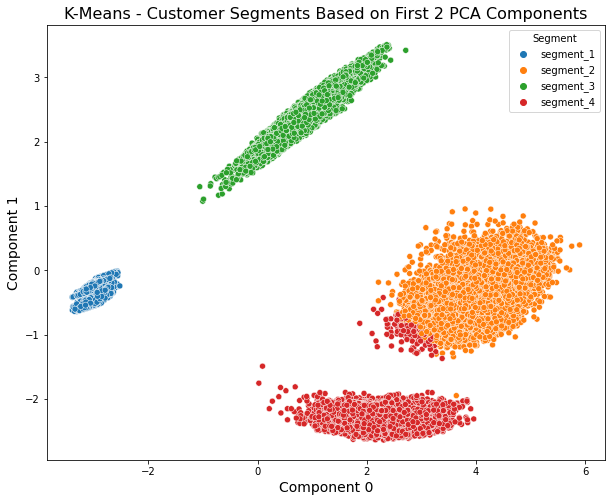

In [33]:
# Set the values for x and y based on the first and second components
x = pets_pca_kmeans["Component_0"]
y = pets_pca_kmeans["Component_1"]

plt.figure(figsize=(10,8))
sns.scatterplot(x=x, y=y, data=pets_pca_kmeans, hue="Segment")
plt.xlabel("Component 0", fontsize=14)
plt.ylabel("Component 1", fontsize=14)
plt.title("K-Means - Customer Segments Based on First 2 PCA Components", fontsize=16)
plt.savefig('../figures/KMeans-Clusters.png')
plt.show()

Looking at the result above, it seems clear that the clusters observed during PCA are holding up reasonably well after applying K-Means. That said, we do see some bleed over from segment 4 to segment 2. 

We know that K-Means assumes spherical shapes of clusters and doesn't work well when clusters are in different shapes such as elliptical clusters. So before we dive to deep into analyzing the clusters assigned above, let's try clustering with DBSCAN which tends to perform better for clusters of arbitrary shape.

## 6 Determine Number of Clusters using DBSCAN
With DBSCAN, we'll follow a similar approach to what we did for KMeans. First though, we need to determine a couple of the key parameters for our DBSCAN implementation, min_samples and eps. 

Min_samples determines the number of samples in a neighborhood for a point to be considered as a core point. It's typical for this value to be set around 2 times the number of features in the data. 

Eps, which is probably the most critical value for DBSCAN, determines the maximum distance between two samples for one to be considered as in the neighborhood of the other. Eps tends to be a bit more difficult to determine. So to help with this, we'll use NearestNeighbors to try and find the optimal value of eps. (A technique described in more detail in this [Medium article](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc).)

### 6.1 Use NearestNeighbors to Determine the Optimal eps Value

In [34]:
# Fit NearestNeighbors to our transformed PCA data 
nbrs = NearestNeighbors(n_neighbors=6).fit(pets_pca_x)

# Create an array with the distances of the closest n-neighbors points and their respective indices
distances, indices = nbrs.kneighbors(pets_pca_x)

# Sort the distances in descending order  
sorted_distances = np.sort(distances[:,-1], axis=0)

# Preview distances
distances.shape

(50000, 6)

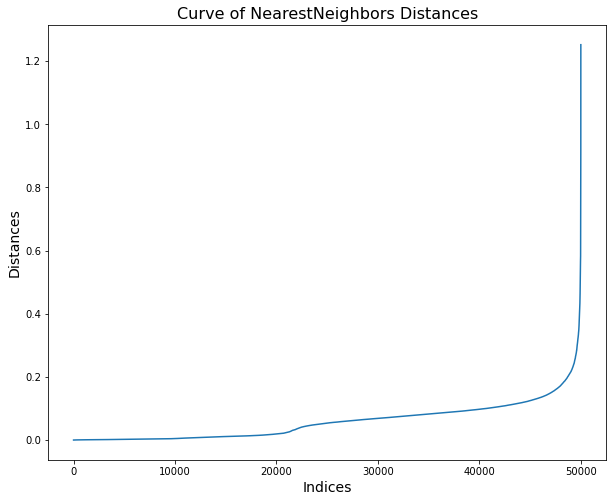

In [35]:
# Plot the result
plt.figure(figsize=(10,8))
plt.plot(sorted_distances)
plt.xlabel("Indices", fontsize=14)
plt.ylabel("Distances", fontsize=14)
plt.title("Curve of NearestNeighbors Distances", fontsize=16)
plt.savefig('../figures/EPS-Determination.png')
plt.show()

Using this method for determining the optimal eps value, we look for the point in the plot where we see the maximum curvature. In the above, this appears to be around 0.2. So for our first interation of DBSCAN, we'll use eps=0.2 and min_samples=12.

### 6.2 Implement DBSCAN to Determine Number of Clusters

In [36]:
# Implement dbscan using our transformed data
dbscan_pca = DBSCAN(eps=0.2, min_samples=12).fit(pets_pca_x)

In [37]:
# Create new df with original features + PCA results
pets_pca_dbscan = pd.concat([pets.reset_index(drop=True), pd.DataFrame(pets_pca_x)], axis=1)
pets_pca_dbscan.columns.values[-3: ] = ["Component_0", "Component_1", "Component_2"]

# Add results of K-Means clustering as a new feature
pets_pca_dbscan["Segment"] = dbscan_pca.labels_

# Preview the segments and value counts for each
pets_pca_dbscan["Segment"].value_counts()

 1    22439
 2    10151
 3    10052
 0     5860
-1     1455
 4       27
 5       16
Name: Segment, dtype: int64

In our initial implementation, we ended up with 4 relatively large clusters in the data (0-3), two very tiny clusters (4 and 5) and a decent number of values that are considered noise (designated as '-1'). Based on our plot after PCA, we know we should see 4 pretty strong clusters in the data.

Next, let's try tweaking our eps value slightly to see if we arrive at a clustering result that is closer to what we observed after PCA.

In [38]:
# Implement dbscan using our transformed data
dbscan_pca = DBSCAN(eps=0.3, min_samples=12).fit(pets_pca_x)

In [39]:
# Create new df with original features + PCA results
pets_pca_dbscan = pd.concat([pets.reset_index(drop=True), pd.DataFrame(pets_pca_x)], axis=1)
pets_pca_dbscan.columns.values[-3: ] = ["Component_0", "Component_1", "Component_2"]

# Add results of K-Means clustering as a new feature
pets_pca_dbscan["Segment"] = dbscan_pca.labels_

# Preview the segments and value counts for each
pets_pca_dbscan["Segment"].value_counts()

 1    22441
 2    10919
 3    10248
 0     6112
-1      280
Name: Segment, dtype: int64

Much better... we see that by tweaking our eps value to 0.3, we now have 4 well defined clusters in the data with a small percentage (< 1%) of the points considered to be noise.

Now let's plot the result to get a visualization of our clusters.

### 6.3 Plot the DBSCAN Clusters

In [40]:
# Add names for each of our segments
pets_pca_dbscan["Segment"] = pets_pca_dbscan["Segment"].map({0: 'segment_1', 1: 'segment_2',
                                                             2: 'segment_3', 3: 'segment_4'})
# Set categorical order of segments for plotting
pets_pca_dbscan["Segment"] = pd.Categorical(pets_pca_dbscan["Segment"] ,
                                   categories=['segment_1', 'segment_2', 'segment_3', 'segment_4'], ordered=True)

# View count of each customer segment
pets_pca_dbscan["Segment"].value_counts().sort_index(ascending=True)

segment_1     6112
segment_2    22441
segment_3    10919
segment_4    10248
Name: Segment, dtype: int64

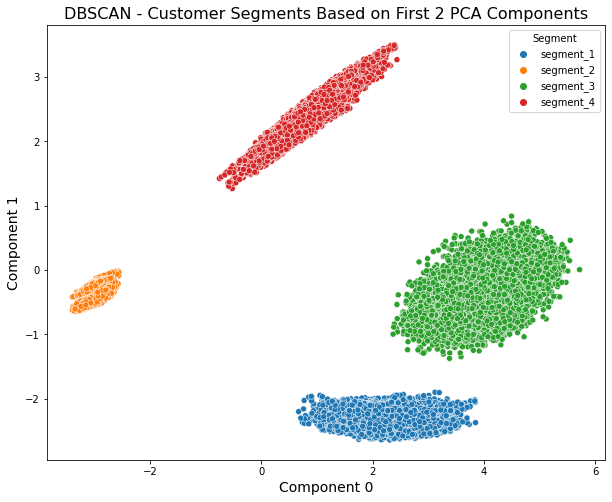

In [41]:
# Set the values for x and y based on the first and second components
x = pets_pca_dbscan["Component_0"]
y = pets_pca_dbscan["Component_1"]

plt.figure(figsize=(10,8))
sns.scatterplot(x=x, y=y, data=pets_pca_dbscan, hue="Segment")
plt.xlabel("Component 0", fontsize=14)
plt.ylabel("Component 1", fontsize=14)
plt.title("DBSCAN - Customer Segments Based on First 2 PCA Components", fontsize=16)
plt.savefig('../figures/DBSCAN-Customer-Segments.png')
plt.show()

Nice! The clustering result above seems to be more inline with what we are observing in our data. So it does look like DBSCAN did a better job of assigning our points to clusters than K-Means in this scenario.

Now that we have our clusters identified and our points are labeled appropriately, let's try to get a better understanding of why our points are clustered in this way. In other words... what in our data is leading us to this result for customer segmentation and how can we better describe the customers in each segment?

## 7 Customer Segment Analysis
During EDA, we observed that Species appears to be an important facet of our data. In addition, we know the Marketing team typically views the customer base in terms of "Dog owners" and "Cat owners". But, does species really factor in to our observed customer segments? Let's take a look, by generating the same scatterplot and adding a hue for species.

### 7.1 Species

In [42]:
# Add species back to our dataframe
pets_pca_dbscan["Species"] = pets_categorical["Species"]
pets_pca_dbscan.head().T

,0,1,2,3,4
Premium,84.54,50.33,74.0,57.54,60.69
Deductible,200,500,500,500,700
AgeYr1,3,0,0,0,0
AmtClaimsYr1,0.0,0.0,640.63,0.0,7212.25
AmtClaimsYr2,1242.0,0.0,1187.68,0.0,168.75
AvgClaimsYr1,621.0,0.0,237.54,0.0,168.75
AvgClaimsYr2,621.0,0.0,237.54,0.0,168.75
NumClaimsYr1,0,0,3,0,9
NumClaimsYr2,2,0,5,0,1
MaxClaim,624.0,0.0,336.56,0.0,3103.4


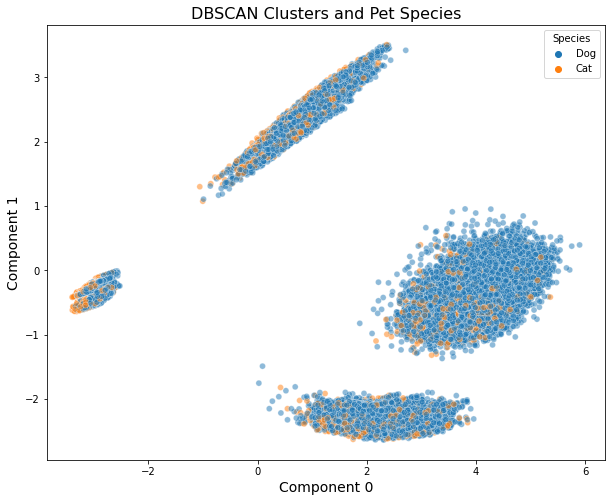

In [43]:
# Set the values for x and y based on the first and second components
x = pets_pca_dbscan["Component_0"]
y = pets_pca_dbscan["Component_1"]

plt.figure(figsize=(10,8))
sns.scatterplot(x=x, y=y, data=pets_pca_dbscan, hue="Species", alpha=0.5)
plt.xlabel("Component 0", fontsize=14)
plt.ylabel("Component 1", fontsize=14)
plt.title("DBSCAN Clusters and Pet Species", fontsize=16)
plt.savefig('../figures/DBSCAN-Customer-Segments-by-Species.png')
plt.show()

Based on the above, it doesn't seem that species factors in much in terms of our customer segments. For now, we'll drop species and continue our analysis. We do know that 'YrsWithClaims' factored prominently into our first component. Let's see how the above plot looks when we include this dimension.

### 7.2 Years with Claims

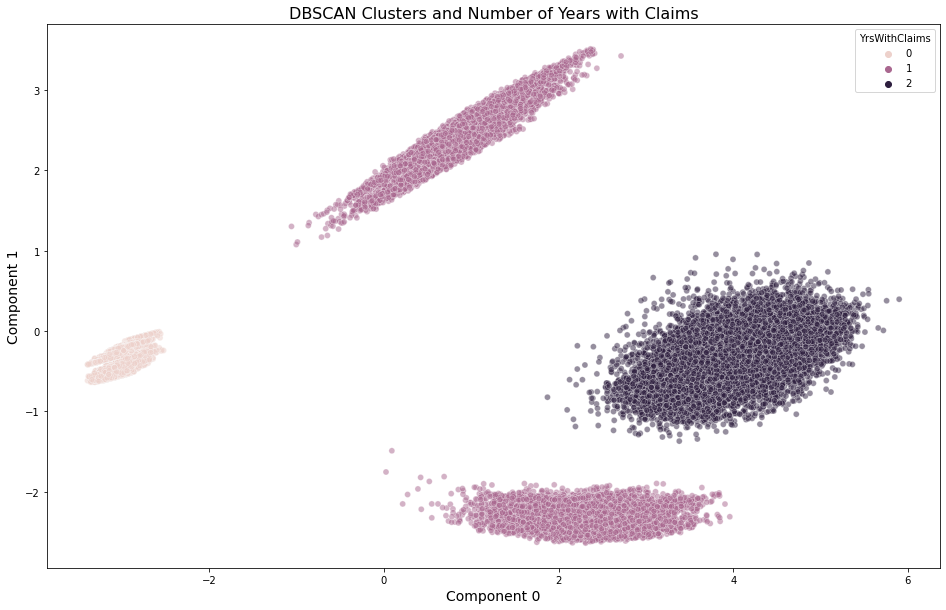

In [44]:
# Set the values for x and y based on the first and second components
x = pets_pca_dbscan["Component_0"]
y = pets_pca_dbscan["Component_1"]

plt.figure(figsize=(16,10))
sns.scatterplot(x=x, y=y, data=pets_pca_dbscan, hue="YrsWithClaims", alpha=0.5)
plt.xlabel("Component 0", fontsize=14)
plt.ylabel("Component 1", fontsize=14)
plt.title("DBSCAN Clusters and Number of Years with Claims", fontsize=16)
plt.savefig('../figures/DBSCAN-Customer-Segments-by-YrsWithClaims.png')
plt.show()

This looks much more promising. We can clearly see that the clusters in the above plot tend to correspond well (if not exactly) with the 'YrsWithClaims' feature. Let's drill into the specific counts for each segment to see if this makes things a little clearer.

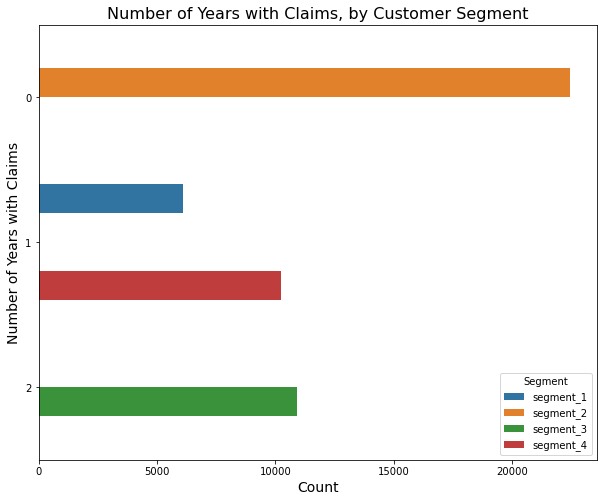

In [45]:
# Create a countplot to show number of years with claims by customer segment
plt.figure(figsize=(10,8))
sns.countplot(y="YrsWithClaims", hue="Segment", data=pets_pca_dbscan)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Number of Years with Claims", fontsize=14)
plt.title("Number of Years with Claims, by Customer Segment", fontsize=16)
plt.savefig('../figures/DBSCAN-Count-of-YrsWithClaims-by-Segment.png')
plt.show()

The plot above confirms our observations from the scatterplot. It appears we have a pretty clear breakdown in terms of customer segments along the lines of the number of years with claims. 

Based on this, we have some initial findings:
* Segment 2 - Customers with no claims over the first two policy years
* Segment 3 - Customers with claims in both of the first two policy years 

We'll need to do a bit more analysis on segments 1 and 4 to determine what is differentiating these customers though. 

### 7.3 Differentiating Segments 1 and 4
Based on the earlier plot, it's clear that all customers in segment 1 and segment 4 have claims in only one of the two policy years in our data. The question is, what differentiates customers in segment 1 from customers in segment 4? 

Given the emphasis our model is putting on 'YrsWithClaims' and the fact that this was the most important feature affecting Component 0 in PCA, my initial assumption is that the difference between segments 1 and 4 has something to do with the claims data. Looking back at the feature importance analysis for Component 1 shows that the top 6 features in terms importance were all related to the number, amount and average claims in either year 1 or year 2. This evidence further supports this initial assumption, but let's take a look to confirm. 

#### 7.3.1 Number of claims in year 1

First, we'll isolate the pets in segments 1 and 4 with claims in only one policy year. Then we'll take a look at the claims data for these segments in years 1 and 2.

In [46]:
# Isolate pets in segments 2 and 3
oneyrclaims = pets_pca_dbscan.copy()
oneyrclaims = oneyrclaims[oneyrclaims["YrsWithClaims"] == 1]

# Reset the categorical feature for segment
oneyrclaims["Segment"] = pd.Categorical(oneyrclaims["Segment"], 
                                             categories=['segment_1', 'segment_4'], ordered=True)

In [47]:
# Compare the number of claims in year 1 for both segments
print("The average number of claims in year 1 for pets in Segments 1 and 4:")
oneyrclaims.groupby(by="Segment")["NumClaimsYr1"].mean()

The average number of claims in year 1 for pets in Segments 1 and 4:


Segment
segment_1    0.000000
segment_4    2.751171
Name: NumClaimsYr1, dtype: float64

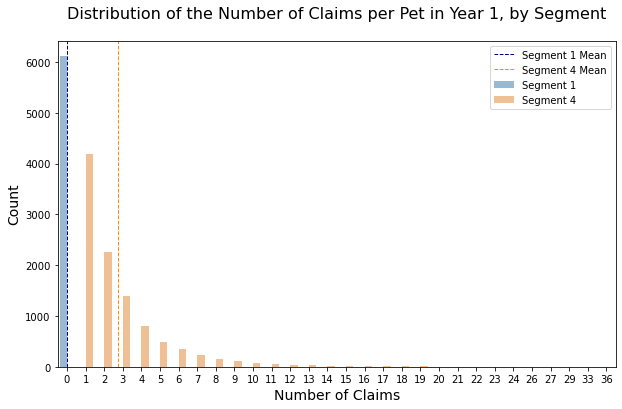

In [48]:
# Calculate mean values
seg1_mean = oneyrclaims[oneyrclaims["Segment"] == "segment_1"]['NumClaimsYr1'].mean()
seg4_mean = oneyrclaims[oneyrclaims["Segment"] == "segment_4"]['NumClaimsYr1'].mean()

# Create a countplot 
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.countplot(x="NumClaimsYr1", data=oneyrclaims, hue="Segment", alpha=0.5)

# Plot mean premium amount for dogs and cats
plt.axvline(seg1_mean, color='darkblue', linestyle='dashed', linewidth=1, label="Segment 1 Mean")
plt.axvline(seg4_mean, color='darkorange', linestyle='dashed', linewidth=1, label="Segment 4 Mean")

# Add title and display plot
plt.title("Distribution of the Number of Claims per Pet in Year 1, by Segment", y=1.05, fontsize=16)
plt.xlabel("Number of Claims", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(labels=(['Segment 1 Mean', 'Segment 4 Mean', 'Segment 1', 'Segment 4']), loc='upper right')
plt.savefig('../figures/Number-Claims-by-Segment-Yr1.png')
plt.show()

So it seems clear that customers in segment 4 have some number of claims in year 1 and customers in segment 1 do not. How does this result look when we compare claims for each segment in year 2?

#### 7.3.2 Number of claims in year 2

In [49]:
# Compare the number of claims in year 2 for both segments
print("The average number of claims in year 2 for pets in Segments 1 and 4:")
oneyrclaims.groupby(by="Segment")["NumClaimsYr2"].mean()

The average number of claims in year 2 for pets in Segments 1 and 4:


Segment
segment_1    3.242474
segment_4    0.000000
Name: NumClaimsYr2, dtype: float64

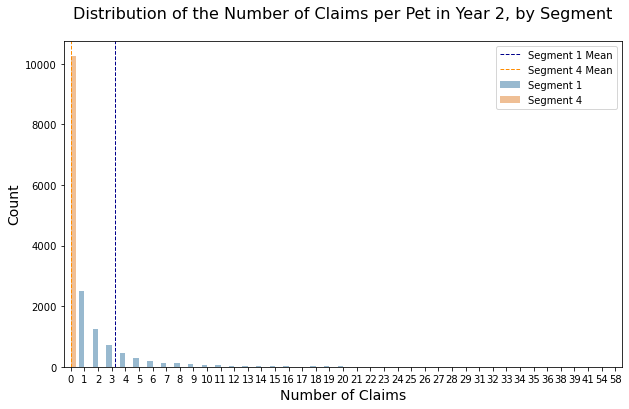

In [50]:
# Calculate mean values
seg1_mean = oneyrclaims[oneyrclaims["Segment"] == "segment_1"]['NumClaimsYr2'].mean()
seg4_mean = oneyrclaims[oneyrclaims["Segment"] == "segment_4"]['NumClaimsYr2'].mean()

# Create a countplot 
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.countplot(x="NumClaimsYr2", data=oneyrclaims, hue="Segment", alpha=0.5)

# Plot mean premium amount for dogs and cats
plt.axvline(seg1_mean, color='darkblue', linestyle='dashed', linewidth=1, label="Segment 1 Mean")
plt.axvline(seg4_mean, color='darkorange', linestyle='dashed', linewidth=1, label="Segment 4 Mean")

# Add title and display plot
plt.title("Distribution of the Number of Claims per Pet in Year 2, by Segment", y=1.05, fontsize=16)
plt.xlabel("Number of Claims", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(labels=(['Segment 1 Mean', 'Segment 4 Mean', 'Segment 1', 'Segment 4']), loc='upper right')
plt.savefig('../figures/Number-Claims-by-Segment-Yr2.png')
plt.show()

We can see in the above that our initial assumption was correct. Pets in Segment 1 have claims in policy year 2 and pets in segment 4 have claims only in policy year 1.

## 8 Conclusions
So overall, our customer segments are:
* **Segment 1** - Customers with claims only in the second policy year
* **Segment 2** - Customers with no claims over the first two policy years
* **Segment 3** - Customers with claims in both of the first two policy years 
* **Segment 4** - Customers with claims only in the first policy year

### 8.1 Segmentation Options
    
Within this result, the Marketing team should have a few options for slicing and dicing customers to arrive at the best combination for a specific outreach goal. For example, if the goal is to demonstrate value for customers with no claims, or no recent claims, Marketing can target customers in Segments 2 and 4. In contrast, if the goal is to target customers making consistent claims or whose claims are on the rise, Marketing can focus on customers in segments 1 and 3.

### 8.2 Data Export

As a final step, we'll export our final data file retaining our customer segmentation result.

In [51]:
# Write final df to csv 
pets_pca_dbscan.to_csv('../data/pets_pca_dbscan.csv')